In [11]:
library(Seurat)
seurat = readRDS('initialseurat_spike2.RDS')

In [13]:
meta =readRDS('BCRmeta.RDS')
seurat@meta.data = meta[colnames(seurat),]

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6751
Number of edges: 247149

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8858
Number of communities: 11
Elapsed time: 2 seconds


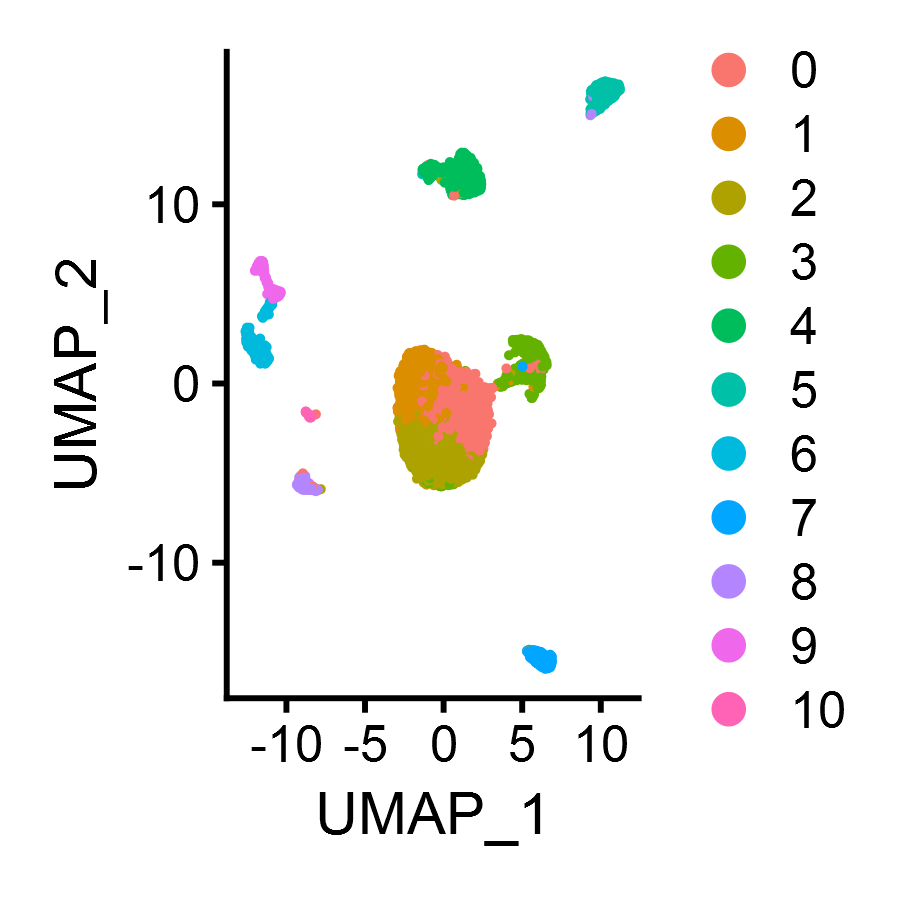

In [13]:
options(repr.plot.res = 300,  repr.plot.height = 3, repr.plot.width = 3)

seurat = FindNeighbors(seurat, dims = 1:20)
seurat = FindClusters(seurat, resolution =  .4)
DimPlot(seurat)

In [14]:
library(ggplot2)
library(dplyr)
UMAP_theme <- theme_bw()+theme(axis.text.y = element_blank(), 
                               axis.text.x = element_blank(), 
                               axis.ticks.x= element_blank(),
                               axis.ticks.y= element_blank(),
                               axis.title.x= element_blank(),
                               axis.title.y= element_blank(),
                               strip.text.x = element_text(size = 8),
                               panel.grid.major = element_blank(),
                               panel.grid.minor = element_blank(),
                               panel.border = element_blank(),
                               panel.background = element_rect(colour = "black", fill = NA,size=.355),
                               legend.position = "none",
                               plot.title = element_text(hjust = 0.5, size = 8))

remove_grid = theme_bw() + theme( panel.grid.major = element_blank(),
                               panel.grid.minor = element_blank())

Axis_themes <- theme(plot.title = element_text(size = 8),
                     axis.title = element_text(size = 8), 
                     axis.text = element_text(size = 8),
                     axis.text.x = element_text(size = 8),
                     legend.text = element_text(size =8),
                     legend.title = element_text(size = 8),
                     strip.text.x = element_text(size = 8), 
                    axis.line = element_line(size = .355), 
                    axis.ticks = element_line(size = .177))


In [15]:
seurat$pheno = 'Non-B cell'
seurat$pheno[Idents(seurat) == 1] = 'Naive B cell'
seurat$pheno[Idents(seurat) %in% c(0, 2)] = 'MBC'
seurat$pheno[Idents(seurat) == 4] = 'PB'
seurat$pheno[Idents(seurat) == 3] = 'HEK cell'


In [16]:
igh_all = rownames(seurat)[grep(x = rownames(seurat), pattern = '^IGH')]
seurat$IGH_sum = colSums(GetAssayData(seurat, 'counts')[igh_all,])#/seurat$nCount_RNA

igk_all = rownames(seurat)[grep(x = rownames(seurat), pattern = '^IGK')]
seurat$IGK_sum = colSums(GetAssayData(seurat, 'counts')[igk_all,])#/seurat$nCount_RNA

igl_all = rownames(seurat)[grep(x = rownames(seurat), pattern = '^IGL')]
seurat$IGL_sum = colSums(GetAssayData(seurat, 'counts')[igl_all,])#/seurat$nCount_RNA

#seurat$pheno[Idents(seurat) == 5 & seurat$IGH_sum > 3] = 'BCR+ HEK cell'

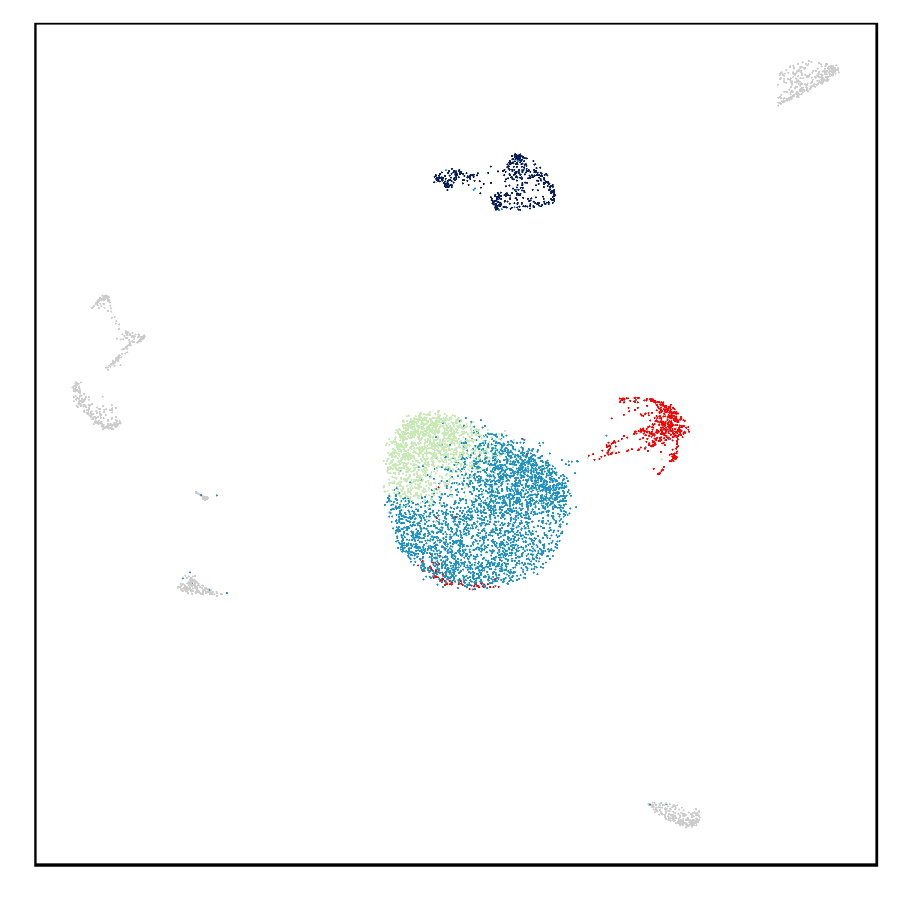

In [17]:
library(ggrastr)
library(RColorBrewer)
seurat$pheno = factor(seurat$pheno, levels =c ('Non-B cell', 'Naive B cell', 'MBC','PB', 'HEK cell'))

cluster_palette = c('grey80', brewer.pal(9, 'YlGnBu')[c(3,6,9)], 'red') 
ggplot(seurat@meta.data[sample(rownames(seurat@meta.data)),], aes(x = UMAP1,  y = UMAP2, color = pheno)) + geom_point_rast(size = .2, stroke = 0, raster.dpi = 1000) + UMAP_theme + scale_color_manual(values = cluster_palette)
ggsave('Figures/umap.pdf', height = 2, width = 2, useDingbats = FALSE)

[1] "CD19"    "MS4A1"   "IGHM"    "IGHD"    "PAX5"    "FCRL1"   "FCRL3"  
 [8] "PRDM4"   "NFKBIA"  "NT5E"    "KLF6"    "GPR183"  "HLA-DRA" "IGHG1"  
[15] "CD38"    "XBP1"    "PRDM1"   "MZB1"    "IRF4"

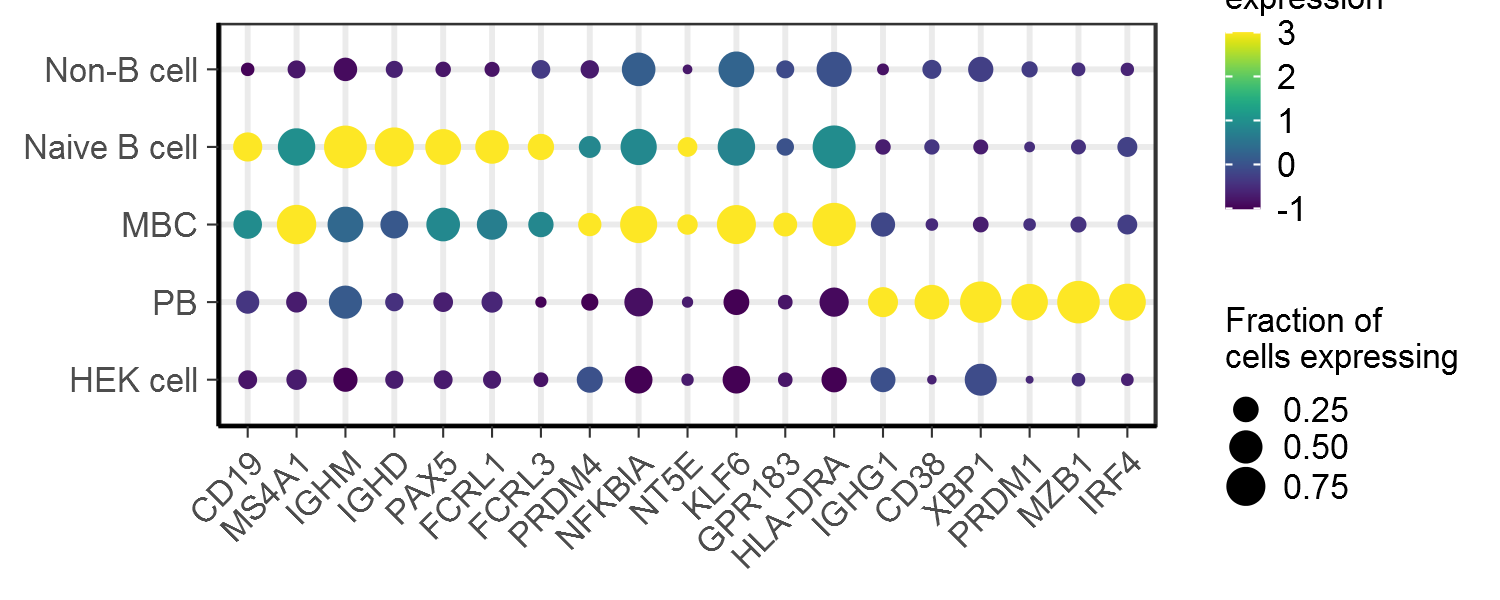

In [18]:
options(repr.plot.width = 5, repr.plot.height = 2)
DefaultAssay(seurat) = 'RNA'
genes = c('CD19', 'MS4A1', "IGHM", 'IGHD', 'PAX5', 'FCRL1', 'FCRL3','PRDM4', 'NFKBIA', 'NT5E', 'KLF6', 'GPR183','HLA-DRA','IGHG1',   'CD38', 'XBP1', 'PRDM1', 'MZB1', 'IRF4')  
genes[]
pct = function(x) {
  sum(x >0)/length(x)
}
meanexp = function(x) {
    mean(x)
}

data = as.data.frame(t(as.matrix(GetAssayData(seurat)[genes,])))

library(reshape2)
library(viridis)
data$phenotype = seurat$pheno
df_exp = data %>% group_by(phenotype) %>% summarize_all(.funs = list(meanexp)) %>% as.data.frame() 
df_exp[,2:(1+length(genes))] = scale(df_exp[,2:(1+length(genes))])
df_exp = df_exp %>% melt(id.vars = 'phenotype')
df_pct = data %>% group_by(phenotype) %>% summarize_all(.funs = list(pct)) %>% melt(id.vars = 'phenotype')
df_exp$value[df_exp$value > 1] = 3
df_exp$value[df_exp$value < -1]= -1

df_exp$pct = df_pct$value

lvs = levels(factor(df_exp$phenotype))

ggplot(as.data.frame(df_exp), aes(y = phenotype, x = variable, size = pct, color = value)) + geom_point() + scale_color_viridis()  + 
 theme_bw()  + theme(axis.title = element_blank()) +# guides(size = FALSE, color = FALSE) + 
labs(color = "Scaled\nexpression", size = 'Fraction of\ncells expressing') + scale_x_discrete(limits = genes) + Axis_themes + 
theme(legend.key.size = unit(.3, 'cm'), axis.title = element_blank(), axis.text.x = element_text(size = 8, hjust = 1, angle = 45)) + scale_y_discrete(limits = rev(lvs))+ scale_size_continuous(range = c(.01, 4), breaks = c(0,.25, .5, .75))

ggsave('Figures/dots.pdf', useDingbats = FALSE, width = 4.5, height = 1.8)


`summarise()` has grouped output by 'orig'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'cluster_name'. You can override using the `.groups` argument.
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`


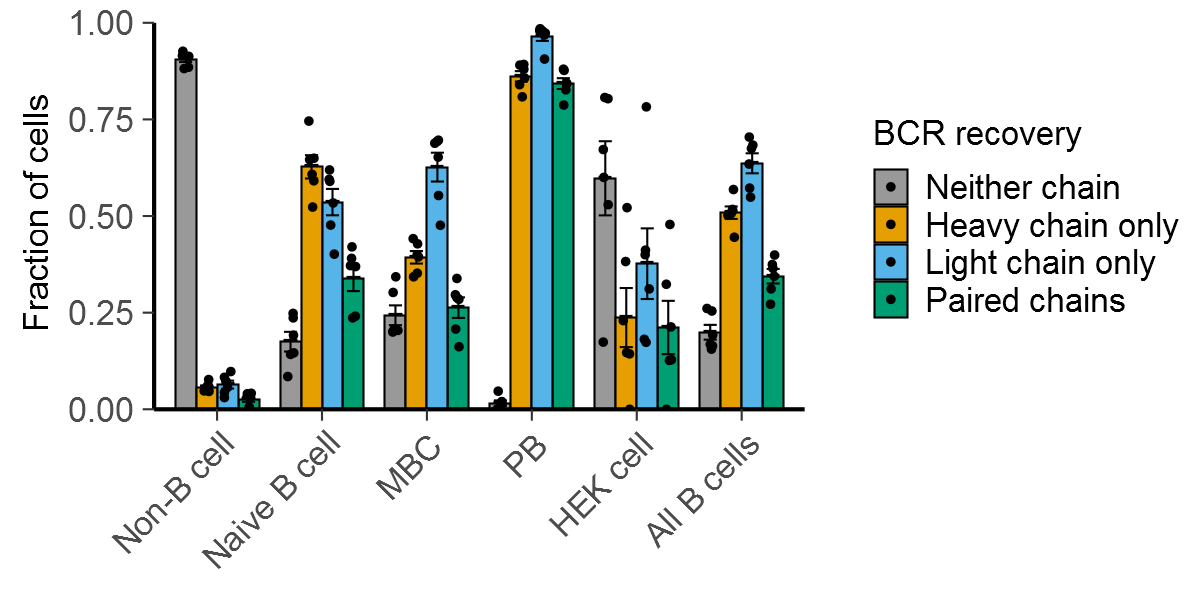

In [21]:
seurat$cluster_name = seurat$pheno
seurat$cluster_name = factor(seurat$cluster_name, levels = c('Non-B cell', 'Naive B cell', 'MBC', 'PB', 'HEK cell', 'BCR+ HEK cell'))
options(repr.plot.width = 4)
cbp1 <- c("#999999", "#E69F00", "#56B4E9", "#009E73",
          "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

df = seurat@meta.data %>% group_by(orig, cluster_name) %>% summarize(none = sum(IGH_recovery == 0 & IGL_recovery== 0)/n(),   both = sum(IGH_recovery * IGL_recovery)/n(),IGH_recovery = sum(IGH_recovery == 1)/n(), tot = n(), IGL_recovery = sum(IGL_recovery == 1)/n(), 
                                                                                                   ) %>% tidyr::complete(fill = list(frac = 0))
library(reshape2)

also = seurat@meta.data %>% filter(cluster_name != 'Non-B cell', cluster_name != 'HEK cell', cluster_name != 'BCR+ HEK cell') %>% group_by(orig)%>% summarize(none = sum(IGH_recovery == 0 & IGL_recovery== 0)/n(),   both = sum(IGH_recovery * IGL_recovery)/n(),IGH_recovery = sum(IGH_recovery == 1)/n(), tot = n(), IGL_recovery = sum(IGL_recovery == 1)/n(), 
                                                                                                   ) %>% tidyr::complete(fill = list(frac = 0)) %>% mutate(cluster_name = 'All B cells')

df$cluster_name = factor(df$cluster_name, levels = c(levels(seurat$cluster_name), 'All B cells'))
df = rbind(df, also)


df2 = melt(df, id.vars = c('orig', 'cluster_name'))
df2 = df2 %>% group_by(cluster_name,  variable) %>% summarize(mean = mean(value), sd = sd(value)/sqrt(n()), n = n()) %>% mutate(ymin = mean-sd, ymax = mean+sd)

df3 = melt(df, id.vars = c('orig', 'cluster_name')) %>% filter(variable != 'tot')
df3$cluster_name = factor(df3$cluster_name, levels = c(levels(seurat$cluster_name), 'All B cells'))
df3$variable = factor(df3$variable, levels = c('none', 'IGH_recovery', 'IGL_recovery', 'both'))
df2$variable =  factor(df2$variable, levels = c('none', 'IGH_recovery', 'IGL_recovery', 'both'))

dodgewidth = .8

ggplot(df3, aes(x = cluster_name, y = value, group = variable))  + 
stat_summary(data = df2 %>%filter(variable != 'tot'), aes(y = mean), geom='crossbar', size = .177, width = .5, position = position_dodge(width = dodgewidth)) + geom_col(data = df2 %>% filter(variable != 'tot'),  aes(x = cluster_name, y = mean, fill = variable), position = position_dodge(width = dodgewidth), width = dodgewidth, color = 'black', size = .177) + 
 geom_point(aes(group = variable, fill = variable), position = position_jitterdodge(dodge.width = dodgewidth, jitter.width = .2), size= .2, color = 'black') +
geom_errorbar(data = df2%>%filter(variable != 'tot'), aes(y = mean, ymin = ymin, ymax = ymax), size = .177,  width = .5, position = position_dodge(width = dodgewidth))  + 
labs(x = c(), y = 'Fraction of cells', color = 'BCR Recovery') + theme_classic() + Axis_themes + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + scale_color_manual(
values = cbp1, labels = c('Neither chain', 'Heavy chain only', "Light chain only", 'Paired chains')) + scale_fill_manual(values = cbp1, labels = c('Neither chain', 'Heavy chain only', "Light chain only", 'Paired chains'))  + 
guides(color = FALSE) + scale_x_discrete(limits = c('Non-B cell', 'Naive B cell', "MBC", 'PB', 'HEK cell',  'All B cells')) + 
theme(legend.key.size = unit(.3, 'cm')) + labs(fill = 'BCR recovery') + scale_y_continuous(expand = c(0,0), limits = c(0,1))
ggsave('Figures/recovery_bars.pdf', height = 2, width = 3.5, useDingbats = FALSE)

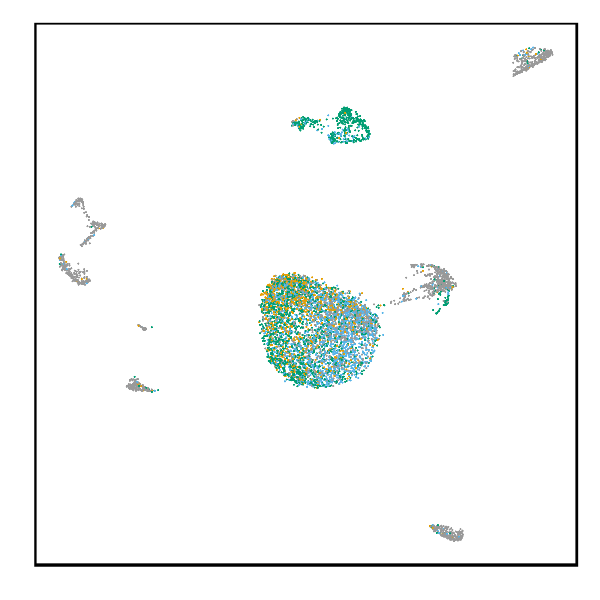

In [22]:
options(repr.plot.width = 2, repr.plot.height = 2)
ggplot(seurat@meta.data[sample(rownames(seurat@meta.data)),], aes(x = UMAP1,  y = UMAP2, color = factor(recovery))) + geom_point_rast(size = .2, stroke = 0, raster.dpi = 1000) + UMAP_theme + scale_color_manual(values =cbp1[c(1,3,2,4)])
ggsave('Figures/umap_recovery.pdf', useDingbats = FALSE, width = 1.8, height = 1.8)


In [23]:
cell_consensus_hc = readRDS('cell_consensus_hc.RDS')
hc = readRDS('hc.RDS')
lc = readRDS('lc.RDS')
cell_consensus_lc = readRDS('cell_consensus_lc.RDS')

In [24]:
library(stringdist)
hc = readRDS('hc.RDS')
hc$pheno = seurat$pheno[match(hc$LANE_ID, seurat$id)]
hek_hc =  hc %>% filter(pheno == 'HEK cell', !STOP)
hek_hc$SEQUENCE_IMGT_USE = substring(hek_hc$SEQUENCE_IMGT, 69, 5000)
hek_hc$dist = stringdistmatrix(hek_hc$SEQUENCE_IMGT_USE, 'TGCAGCCTCTGGTTTCACTTTC............AGTAACGCCTGGATGAACTGGGTCCGCCAGGCTCCAGGGAAGGGGCTGGAGTGGGTCGGCCGTATTAAAAGCAAAACTGATGGTGGGACAACAGACTACGCTGCACCCGTGAAA...GGCAGATTCACCATCTCAAGAGATGATTCAAAAAACACGCTGTATCTGCAAATGAACAGCCTGAAAACCGAGGACACAGCCGTGTATTACTGTACCACAGAGGAGGAGGAGTATTACTATGGTTCGGGGAGTTATTTGGTTGACTACTGGGGCCAGGGAACCATGGTCACCGTCTCTTCAG')

bc_exclude = hek_hc %>% filter(dist > 7) %>% group_by(BC, V_CALL, CDR3_IMGT) %>% select(BC, UMI, V_CALL, CDR3_IMGT) %>% summarize(n = n()) %>% filter(n > 1)
hek_hc  = hek_hc %>% filter(!BC %in% bc_exclude$BC)


table(hek_hc$dist)
hek_hc$same = 1

hek_hc$class = paste0(hek_hc$dist, ' mismatches')
hek_hc$class[hek_hc$dist == 0]  = 'Exact match'
hek_hc$class[hek_hc$dist == 1]  = '1 mismatch'
hek_hc$class[hek_hc$dist > 5] = '6-10 mismatches'
hek_hc$class[hek_hc$dist > 10] = 'Unrelated sequence'

Warning message:
"package 'stringdist' was built under R version 4.1.1"
`summarise()` has grouped output by 'BC', 'V_CALL'. You can override using the `.groups` argument.



  0   1   2   3   5   6   7  15  27  31  36  48  65  77  80  83  84  85  87  91 
675  39   1   2   1   1   1   1   1   1   2   1   1   1   1   1   1   2   1   3 
 98 111 112 113 116 119 121 123 127 128 168 171 191 
  1   1   1   1   1   1   1   1   1   1   1   1   1 

In [25]:
lc = readRDS('lc.RDS')
library(stringr)
lc$pheno = seurat$pheno[match(lc$LANE_ID, seurat$id)]
hek_lc =  lc %>% filter(pheno == 'HEK cell') %>% mutate(gapcount = str_count(SEQUENCE_IMGT, '-')) %>% filter(gapcount < 3  )
hek_lc$SEQUENCE_IMGT_USE = substring(hek_lc$SEQUENCE_IMGT, 69, 5000)
u6lc = '....................TCCATCCTCCCTGTCTGCATCTGTAGGAGACAGAGTCACCATCACTTGCCGGGCAAGTCAGGGCATT..................AGAAATGATTTAGGCTGGTATCAGCAGAAACCAGGGAAAGCCCCTAAGCGCCTGATCTATGCTGCA.....................TCCAGTTTGCAAAGTGGGGTCCCA...TCAAGGTTCAGCGGCAGTGGA......TCTGGGACAGAATTCACTCTCACAATCAGCAGCCTGCAGCCTGAAGATTTTGCAACTTATTACTGTCTACAGCATAATAGTTACCCGCGTACACTTTTGGCCAGGGGACCAAGCTGGAGATCAAAC'
hek_lc= hek_lc %>% mutate(ndot = str_count( FWR1_IMGT, fixed('.'))+1) %>% group_by(SEQUENCE_ID) %>% mutate(SEQUENCE_IMGT_COMPARE = substring(u6lc, ndot, 372), SEQUENCE_IMGT_QUERY = substring(SEQUENCE_IMGT, ndot, 372) ) %>% 
mutate(dist = stringdist(SEQUENCE_IMGT_QUERY, SEQUENCE_IMGT_COMPARE, method = 'lv')) %>% filter(ndot < 78)



bc_exclude = hek_lc %>% filter(dist > 7) %>% group_by(BC, V_CALL, CDR3_IMGT, dist) %>% select(BC, UMI, V_CALL, CDR3_IMGT) %>% summarize(n = n()) %>% filter(n > 1)
hek_lc  = hek_lc %>% filter(!BC %in% bc_exclude$BC)




table(hek_lc$dist)/nrow(hek_lc)
hek_lc$same = 1


hek_lc$class = paste0(hek_lc$dist, ' mismatches')
hek_lc$class[hek_lc$dist == 0]  = 'Exact match'
hek_lc$class[hek_lc$dist == 1]  = '1 mismatch'
hek_lc$class[hek_lc$dist > 5] = '6-10 mismatches'
hek_lc$class[hek_lc$dist > 10] = 'Unrelated sequence'



Adding missing grouping variables: `dist`
`summarise()` has grouped output by 'BC', 'V_CALL', 'CDR3_IMGT'. You can override using the `.groups` argument.



           0            1            2            3            4            5 
0.8906138473 0.0835117773 0.0119557459 0.0024982156 0.0016059957 0.0008922198 
           6            9           10           11           12           14 
0.0003568879 0.0001784440 0.0005353319 0.0003568879 0.0001784440 0.0003568879 
          16           21           22           23           27           30 
0.0003568879 0.0001784440 0.0001784440 0.0001784440 0.0001784440 0.0001784440 
          31           40           45           50           78           81 
0.0001784440 0.0003568879 0.0001784440 0.0001784440 0.0012491078 0.0001784440 
          96          102          104          107          109          115 
0.0001784440 0.0001784440 0.0001784440 0.0001784440 0.0001784440 0.0001784440 
         130          135          136          138          140          142 
0.0001784440 0.0003568879 0.0001784440 0.0007137759 0.0001784440 0.0003568879 
         144          148 
0.0001784440 0.000178444

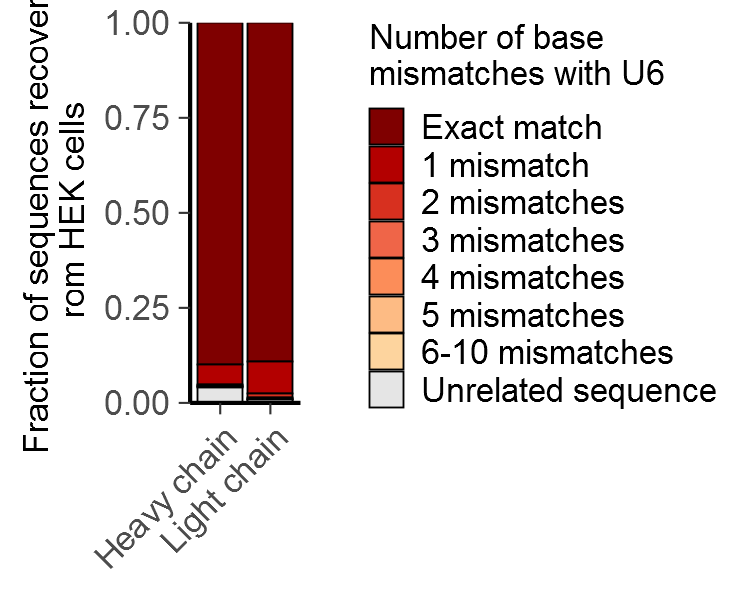

In [26]:
library(RColorBrewer)
options(repr.plot.width = 2.5)
df = rbind(hek_lc, hek_hc) %>% mutate(CHAIN = ifelse(LOCUS == 'IGH', 'Heavy chain', 'Light chain'))
df$class = factor(df$class, levels = c('Exact match', '1 mismatch', '2 mismatches', '3 mismatches', '4 mismatches', '5 mismatches','6-10 mismatches', 'Unrelated sequence'))
ggplot(df, aes(x = CHAIN, fill = class)) + geom_bar(position = 'fill', color = 'black', size = .155) + 
scale_fill_manual(values = c(brewer.pal(9,'OrRd')[c(9,8,7,6,5,4,3)], 'grey90')) + theme_classic() +Axis_themes + labs(x = c(), y = 'Fraction of sequences recovered\nrom HEK cells') + scale_y_continuous(expand = c(0,0)) + 
labs(fill = 'Number of base\nmismatches with U6') + theme(axis.text.x = element_text(angle = 45, hjust = 1), legend.key.size = unit(3, 'mm'))

ggsave('Figures/hek_recovery.pdf', height = 2, width = 2.4, useDingbats = FALSE)

In [15]:
df %>% group_by(CHAIN) %>% summarize(frac = sum(dist<2) /n())

CHAIN,frac
<chr>,<dbl>
Heavy chain,0.9520000
Light chain,0.9741256


In [27]:
all_lc =  lc %>%mutate(gapcount = str_count(SEQUENCE_IMGT, '-')) %>% filter(gapcount < 3  )
all_lc$SEQUENCE_IMGT_USE = substring(all_lc$SEQUENCE_IMGT, 69, 5000)
u6lc = '....................TCCATCCTCCCTGTCTGCATCTGTAGGAGACAGAGTCACCATCACTTGCCGGGCAAGTCAGGGCATT..................AGAAATGATTTAGGCTGGTATCAGCAGAAACCAGGGAAAGCCCCTAAGCGCCTGATCTATGCTGCA.....................TCCAGTTTGCAAAGTGGGGTCCCA...TCAAGGTTCAGCGGCAGTGGA......TCTGGGACAGAATTCACTCTCACAATCAGCAGCCTGCAGCCTGAAGATTTTGCAACTTATTACTGTCTACAGCATAATAGTTACCCGCGTACACTTTTGGCCAGGGGACCAAGCTGGAGATCAAAC'
all_lc= all_lc %>% mutate(ndot = str_count( FWR1_IMGT, fixed('.'))+1) %>% group_by(SEQUENCE_ID) %>% mutate(SEQUENCE_IMGT_COMPARE = substring(u6lc, ndot, 372), SEQUENCE_IMGT_QUERY = substring(SEQUENCE_IMGT, ndot, 372) ) %>% 
mutate(dist = stringdist(SEQUENCE_IMGT_QUERY, SEQUENCE_IMGT_COMPARE, method = 'lv')) %>% filter(ndot < 78)



In [28]:
lc_sub = all_lc %>% filter(dist  < 1, !is.na(pheno), R2CONSCOUNT > 20)
table(lc_sub$pheno)/nrow(lc_sub)


  Non-B cell Naive B cell          MBC           PB     HEK cell 
 0.000000000  0.002599814  0.005571031  0.001299907  0.990529248 

In [29]:
all_hc =  hc %>% filter(!is.na(pheno)) %>% mutate(gapcount = str_count(SEQUENCE_IMGT, '-')) %>% filter(gapcount < 3  )
all_hc$SEQUENCE_IMGT_USE = substring(all_hc$SEQUENCE_IMGT, 69, 5000)
u6hc = '....................................................................TGCAGCCTCTGGTTTCACTTTC............AGTAACGCCTGGATGAACTGGGTCCGCCAGGCTCCAGGGAAGGGGCTGGAGTGGGTCGGCCGTATTAAAAGCAAAACTGATGGTGGGACAACAGACTACGCTGCACCCGTGAAA...GGCAGATTCACCATCTCAAGAGATGATTCAAAAAACACGCTGTATCTGCAAATGAACAGCCTGAAAACCGAGGACACAGCCGTGTATTACTGTACCACAGAGGAGGAGGAGTATTACTATGGTTCGGGGAGTTATTTGGTTGACTACTGGGGCCAGGGAACCATGGTCACCGTCTCTTCAG'
all_hc= all_hc %>% mutate(ndot = str_count( FWR1_IMGT, fixed('.'))+1) %>% group_by(SEQUENCE_ID) %>% mutate(SEQUENCE_IMGT_COMPARE = substring(u6hc, ndot, 372), SEQUENCE_IMGT_QUERY = substring(SEQUENCE_IMGT, ndot, 372) ) %>% 
mutate(dist = stringdist(SEQUENCE_IMGT_QUERY, SEQUENCE_IMGT_COMPARE, method = 'lv')) %>% filter(ndot < 78)



In [30]:
hc_sub = all_hc %>% filter(dist  == 0, !is.na(pheno))
table(hc_sub$pheno)/nrow(hc_sub)


  Non-B cell Naive B cell          MBC           PB     HEK cell 
 0.000000000  0.000000000  0.001436782  0.000000000  0.998563218 

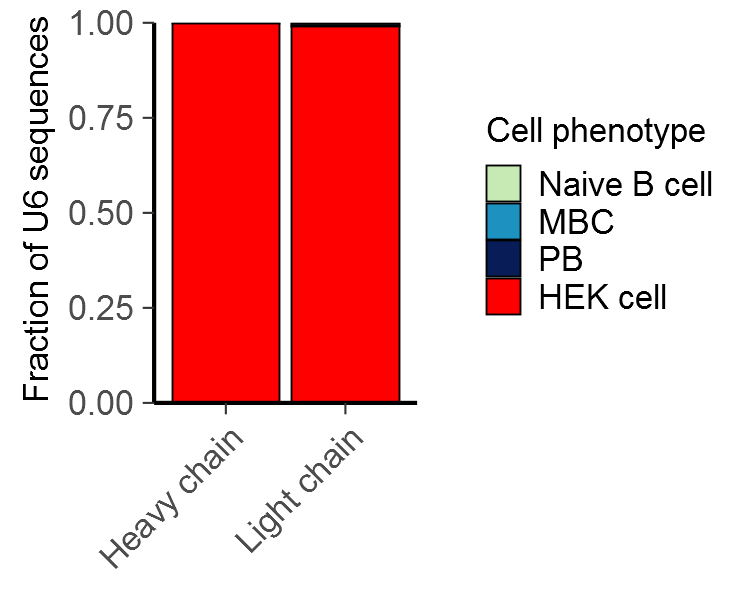

In [31]:
hc_sub$CHAIN = 'Heavy chain'
lc_sub$CHAIN = 'Light chain'
names(cluster_palette) = levels(seurat$pheno)
df = rbind(hc_sub, lc_sub)
ggplot(df, aes(x = CHAIN, fill = pheno)) + geom_bar(position = 'fill', color = 'black', size = .155) + scale_fill_manual(values = cluster_palette) + theme_classic() +Axis_themes + labs(x = c(), y = 'Fraction of U6 sequences') + scale_y_continuous(expand = c(0,0)) + 
labs(fill = c('Cell phenotype')) + theme(axis.text.x = element_text(angle = 45, hjust = 1), legend.key.size = unit(3, 'mm'))
ggsave('Figures/u6_recovery.pdf', height = 2, width = 2.0, useDingbats = FALSE)

In [32]:
table(hc_sub$CHAIN, hc_sub$pheno)

             
              Non-B cell Naive B cell MBC  PB HEK cell
  Heavy chain          0            0   1   0      695

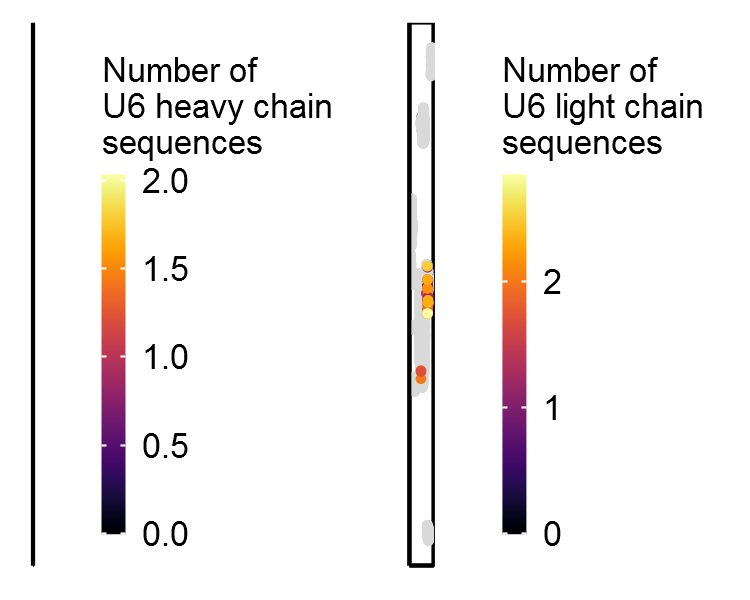

In [33]:
seurat$nheavy = log10(sapply(seurat$id, function(x) sum(hc_sub$LANE_ID ==x)))
seurat$nlight = log10(sapply(seurat$id, function(x) sum(lc_sub$LANE_ID == x)))

g1 = ggplot(seurat@meta.data %>% arrange(nheavy), aes(x = UMAP1, y = UMAP2, color = nheavy)) + geom_point(size = .3) + UMAP_theme + scale_color_viridis(option = 3, na.value   = 'grey85')  + Axis_themes+
                             theme(legend.position = 'right') + labs(color = 'Number of\nU6 heavy chain\nsequences')+ 
                             guides(color =guide_colorbar(barwidth = .4)) + theme(axis.text.x = element_blank())
g2 = ggplot(seurat@meta.data %>% arrange(nheavy), aes(x = UMAP1, y = UMAP2, color = nlight)) + geom_point(size = .3) + 
                             UMAP_theme + scale_color_viridis(option = 3, na.value   = 'grey85')   +Axis_themes+ theme(legend.position = 'right') + labs(color = 'Number of\nU6 light chain\nsequences')   + 
                             guides(color =guide_colorbar(barwidth = .4))+ theme(axis.text.x = element_blank())
cowplot::plot_grid(g1, g2, ncol =2 ) + theme(axis.text.x = element_blank(), legend.key.size = unit(0, 'mm'))
ggsave('Figures/u6umap.pdf', height = 2, width = 6, useDingbats = FALSE)

In [34]:
save.image('20240409_u6.RDATA')

In [20]:
load('20240409_u6.RDATA')

In [39]:
cell_consensus_hc = readRDS('cell_consensus_hc.RDS')
hc = readRDS('hc.RDS')
lc = readRDS('lc.RDS')
cell_consensus_lc = read.table('lc_consensus.tab', header = TRUE, sep = '\t')

In [40]:
head(cell_consensus_lc$V_CALL)

[1] "IGLV8-61*01"             "IGKV3-20*01"            
[3] "IGLV6-57*01"             "IGLV1-44*01,IGLV1-44*02"
[5] "IGLV1-44*01"             "IGLV1-51*02"

In [41]:
seurat@meta.data$IGHV = cell_consensus_hc[match(seurat$id, cell_consensus_hc$LANE_ID), 'GERMLINE_V_CALL']
seurat@meta.data$IGLV = cell_consensus_lc[match(seurat$id, cell_consensus_lc$LANE_ID), 'V_CALL']

In [44]:
library(dplyr)
a = seurat@meta.data %>% filter(!pheno %in% c('Non-B cell', 'HEK cell')) %>% 
mutate(WTA = IGH_sum, VDJ = as.numeric(!is.na(IGHV)), chain = 'IGH', exp = orig, project = 'Seq-Well (HEK experiment)') %>%
select(WTA, VDJ, chain, exp, project)
head(a)

library(dplyr)
b = seurat@meta.data %>% filter(!pheno %in% c('Non-B cell', 'HEK cell')) %>% 
mutate(WTA = IGK_sum, VDJ = as.numeric(!is.na(IGLV)), chain = 'IGK', exp = orig, project = 'Seq-Well (HEK experiment)') %>%
select(WTA, VDJ, chain, exp, project)
head(b)

c = rbind(a, b)

,WTA,VDJ,chain,exp,project
,<dbl>,<dbl>,<chr>,<chr>,<chr>
Y3_10,1,1,IGH,Y3,Seq-Well (HEK experiment)
Y3_17,3,0,IGH,Y3,Seq-Well (HEK experiment)
Y3_22,8,1,IGH,Y3,Seq-Well (HEK experiment)
Y3_26,13,1,IGH,Y3,Seq-Well (HEK experiment)
Y3_32,5,1,IGH,Y3,Seq-Well (HEK experiment)
Y3_35,4,0,IGH,Y3,Seq-Well (HEK experiment)


,WTA,VDJ,chain,exp,project
,<dbl>,<dbl>,<chr>,<chr>,<chr>
Y3_10,2,1,IGK,Y3,Seq-Well (HEK experiment)
Y3_17,0,0,IGK,Y3,Seq-Well (HEK experiment)
Y3_22,1,1,IGK,Y3,Seq-Well (HEK experiment)
Y3_26,1,1,IGK,Y3,Seq-Well (HEK experiment)
Y3_32,0,0,IGK,Y3,Seq-Well (HEK experiment)
Y3_35,0,0,IGK,Y3,Seq-Well (HEK experiment)


In [45]:
saveRDS(c, 'hek_recovery_summary.RDS')